In [1]:
# Basic imports
import geopandas as gpd
from pathlib import Path

# Library imports
from geograypher.cameras.derived_cameras import MetashapeCameraSet
from geograypher.meshes import TexturedPhotogrammetryMesh
from geograypher.utils.visualization import show_segmentation_labels
from geograypher.constants import (
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_DTM_FILE,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_LABELED_MESH_FILENAME,
    EXAMPLE_RENDERED_LABELS_FOLDER,
    EXAMPLE_IDS_TO_LABELS,
    EXAMPLE_LABEL_COLUMN_NAME,
)

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height above the DTM are considered ground
# Something is off about the elevation between the mesh and the DTM, this should be a threshold in meters above ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 1
# Portions of the mesh within this distance of the labels are used for rendering
MESH_BUFFER_RADIUS_METER = 20
# Cameras within this radius of the annotations are used for training
CAMERAS_BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1

## Define the inputs
# The mapping between integer class IDs and string class names
IDS_TO_LABELS = EXAMPLE_IDS_TO_LABELS
# The input labels
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
# Render data from this column in the geofile to each image
LABEL_COLUMN_NAME = EXAMPLE_LABEL_COLUMN_NAME
# The mesh exported from Metashape
MESH_FILENAME = EXAMPLE_MESH_FILENAME
# The camera file exported from Metashape
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
# The digital elevation map exported by Metashape
DTM_FILE = EXAMPLE_DTM_FILE
# The image folder used to create the Metashape project
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER

## Define the intermediate results
# Processed geo file
# Where to save the mesh after labeling
LABELED_MESH_FILENAME = EXAMPLE_LABELED_MESH_FILENAME
# Where to save the rendering label images
RENDER_FOLDER = EXAMPLE_RENDERED_LABELS_FOLDER

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

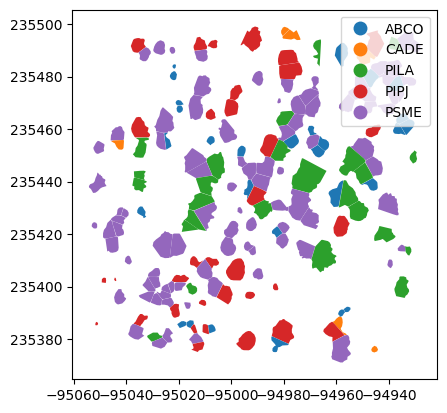

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Show
gdf.plot(LABEL_COLUMN_NAME, legend=True, vmin=-0.5, vmax=9.5, cmap="tab10")

# Load the mesh and read texture from geopolygon

In [4]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        texture=LABELS_FILENAME,
        ROI=LABELS_FILENAME,
        ROI_buffer_meters=MESH_BUFFER_RADIUS_METER,
        IDs_to_labels=IDS_TO_LABELS,
        texture_column_name=LABEL_COLUMN_NAME,
        transform_filename=CAMERAS_FILENAME,
    )
    # Get the vertex textures from the mesh
    texture_verts = mesh.get_texture(
        request_vertex_texture=True, try_verts_faces_conversion=False
    )
    mesh.label_ground_class(
        DTM_file=DTM_FILE,
        height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
        only_label_existing_labels=True,
        ground_class_name="GROUND",
        set_mesh_texture=True,
    )

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Trying to read texture as a scalar from the pyvista mesh:
- failed
Trying to read texture as a numpy file:
- failed
Trying to read texture as vector file:
- success


Sampling values from raster /ofo-share/repos-david/geograypher/data/chips_tree_species/inputs/chips_DTM.tif: 100%|██████████| 204180/204180 [00:07<00:00, 25638.63it/s]


discrete texture, saving classes
Saving IDs_to_labels to labeled_mesh_IDs_to_labels.json


# Load a set of cameras and downsample them to the region around annotations

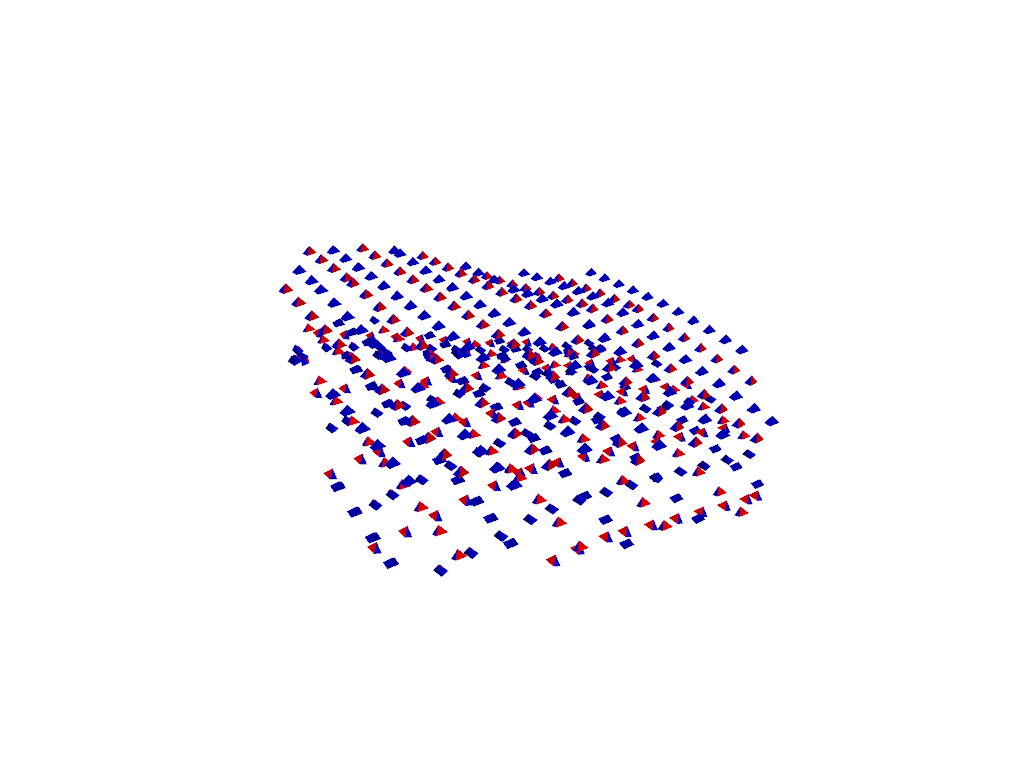

In [5]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius=CAMERAS_BUFFER_RADIUS_METERS
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Show the mesh

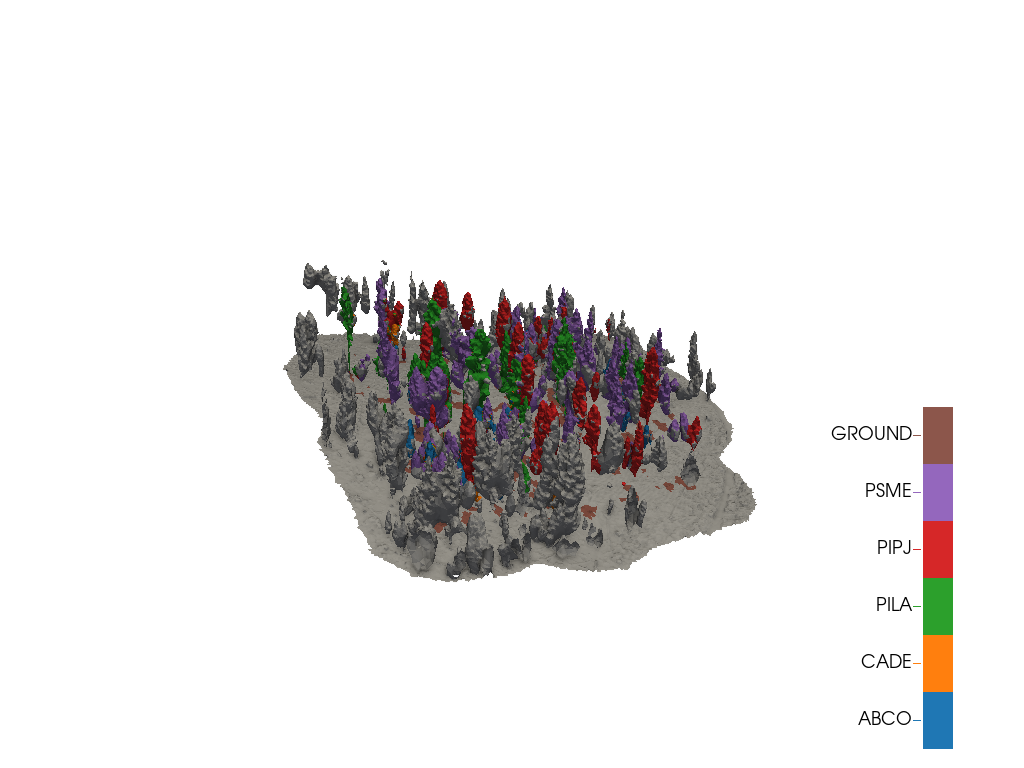

In [6]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True)

# Render the labels onto the images

In [7]:
mesh.save_renders(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders to /ofo-share/repos-david/geograypher/data/chips_tree_species/intermediate_results/rendered_labels
discrete texture, saving classes
Saving IDs_to_labels to /ofo-share/repos-david/geograypher/data/chips_tree_species/intermediate_results/rendered_labels/IDs_to_labels.json


Computing and saving renders: 100%|██████████| 473/473 [10:20<00:00,  1.31s/it]


# Show some of the rendered labels

Showing segmentation labels: 0it [00:00, ?it/s]

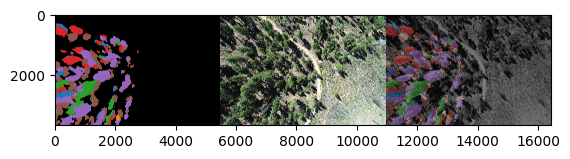

Showing segmentation labels: 1it [00:06,  6.49s/it]

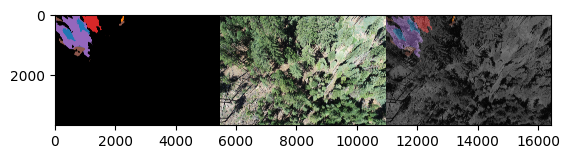

Showing segmentation labels: 2it [00:12,  6.16s/it]

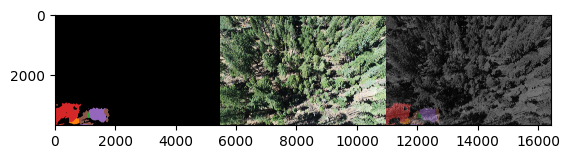

Showing segmentation labels: 3it [00:18,  6.03s/it]

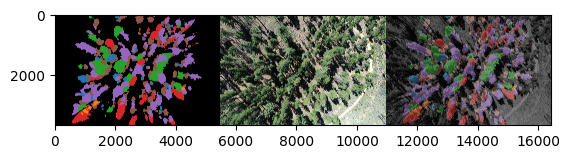

Showing segmentation labels: 4it [00:24,  6.25s/it]

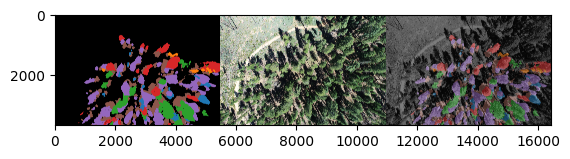

Showing segmentation labels: 5it [00:31,  6.45s/it]

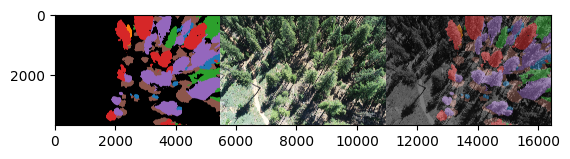

Showing segmentation labels: 6it [00:37,  6.37s/it]

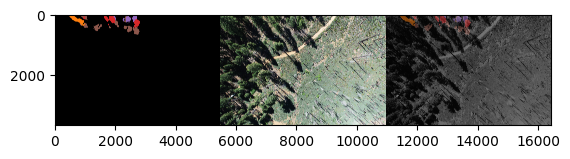

Showing segmentation labels: 7it [00:43,  6.25s/it]

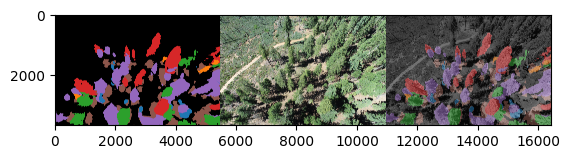

Showing segmentation labels: 8it [00:49,  6.11s/it]

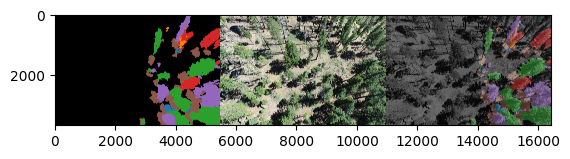

Showing segmentation labels: 9it [00:55,  5.99s/it]

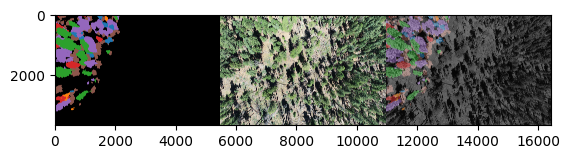

Showing segmentation labels: 10it [01:01,  6.13s/it]


In [8]:
show_segmentation_labels(
    label_folder=RENDER_FOLDER,
    image_folder=IMAGE_FOLDER,
    num_show=10,
    label_suffix=".png",
)